# Modeling Part 2 (testing different models)

In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, string
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import seaborn as sns
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.corpus import stopwords
pd.options.display.max_colwidth = 300


import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

In [76]:
df = pd.read_csv('../data/reddit_dominion_fixed.csv')
df.head()

,title,id,created_utc,year,month,full_link,body_len,word_count,char_count,has_media,num_comments,commments_greater
0,"Dominion Deck Builder | Share, discuss and rate Dominion card combinations",en9hw,1292565223,2010,12,https://www.reddit.com/r/dominion/comments/en9hw/dominion_deck_builder_share_discuss_and_rate/,0,11,74,0,0,0
1,Dominion: Cornucopia announced. Theme: Variety.,f2gt5,1295040872,2011,1,https://www.reddit.com/r/dominion/comments/f2gt5/dominion_cornucopia_announced_theme_variety/,0,5,47,0,1,0
2,Online Dominion,fe1r5,1296680348,2011,2,https://www.reddit.com/r/dominion/comments/fe1r5/online_dominion/,0,2,15,0,3,0
3,Looking for someone to play a multiple rounds,fj3la,1297381276,2011,2,https://www.reddit.com/r/dominion/comments/fj3la/looking_for_someone_to_play_a_multiple_rounds/,274,8,45,0,6,0
4,The Secret History of the Dominion Cards (written by Donald X himself!),fw55j,1299108955,2011,3,https://www.reddit.com/r/dominion/comments/fw55j/the_secret_history_of_the_dominion_cards_written/,0,12,71,0,0,0


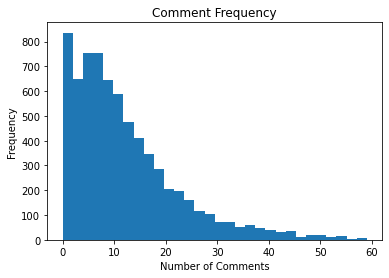

In [310]:
plt.hist(df[df['num_comments']<60]['num_comments'], bins = 30)
plt.title('Comment Frequency')
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')

plt.show()

- ## Initialization

In [143]:
y = df['commments_greater']
X = df[['title', 'year', 'month', 'body_len', 'word_count', 'has_media']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)
X_train_simple = X_train['title']
X_test_simple = X_test['title']

- ## Baseline model

In [131]:
y.value_counts(normalize=True)

0    0.511024
1    0.488976
Name: commments_greater, dtype: float64

- #### If the model predicted majority class (less than or equal to 1 comment), the model would be right 51% of the time. The goal is to improve upon this baseline accuracy.

- ## Define lemmatization and stemming functions

In [172]:
# Used code from https://datagy.io/python-remove-special-characters-from-string/
# to clean strings

# Tested only stemming function
# def lemma_tokenizer(doc):
#     wnl = WordNetLemmatizer()
#     tokens = word_tokenize(doc)
#     return [wnl.lemmatize(t) for t in tokens]

def stemmer_tokenizer(doc):
    ps = PorterStemmer()
    tokens = word_tokenize(doc)
    tokens = [ps.stem(re.sub(r"[^a-zA-Z0-9 ]", "", t)) for t in tokens 
              if t not in stops and t not in string.punctuation] #other languages
    tokens = [re.sub(r'\W+', ' ', t) for t in tokens 
              if t not in stops and t not in string.punctuation] #strange characters
    tokens = [re.sub('\d+', '', t) for t in tokens 
              if t not in stops and t not in string.punctuation ] #numerical
    return [ps.stem(re.sub("\\W",'',t)) for t in tokens 
              if t not in stops and t not in string.punctuation]
stops = set(stopwords.words('english'))

- ## Outline
The following models were tested on just the title data using both CountVectorizer
and TfidfVectorizer. Stemming was applied in each model (lemmatization was skipped
due to time constraints).
- - Logistic Regression
- - Naïve Bayes (Bernoulli and Multinomial)
- - Random forest
- - Gradient Boosting
- - Ada Boost
- - K Nearest Neighbors

A few models were run using more features, including:
- - Logistic Regression
- - Naïve Bayes (Bernoulli)
- - Random Forest
- - Extra Trees
- - K Nearest Neighbors
- - Support Vector Classification

- ## Logistic Regression

### Count Vectorizer

In [144]:
pipe = Pipeline([    
    ('cv', CountVectorizer(tokenizer = stemmer_tokenizer, min_df=3)),
    ('lr', LogisticRegression(max_iter=1000)),
])

params = {
    'cv__ngram_range' : [(1,1),(1,2)],
    'lr__C': [1,1.5,0.5]
}

gs = GridSearchCV(pipe, params, cv=5, verbose=2, n_jobs=-1)
gs.fit(X_train_simple, y_train)
print('Best Params: ', gs.best_params_)
print('Best Estimator Score Train: ', gs.best_estimator_.score(X_train_simple, y_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(X_test_simple, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Params:  {'cv__ngram_range': (1, 2), 'lr__C': 0.5}
Best Estimator Score Train:  0.7696629213483146
Best Estimator Score Test:  0.5760808534531162


### TFID 

In [145]:
pipe = Pipeline([    
    ('tfid', TfidfVectorizer(tokenizer=stemmer_tokenizer, min_df=3)),
    ('lr', LogisticRegression(max_iter=1000)),
])

params = {
    # 'tfid__stop_words' : [None, 'english'],
    'tfid__ngram_range' : [(1,1),(1,2), (2,2)],
}

gs = GridSearchCV(pipe, params, cv=5, verbose=2, n_jobs=-1)

gs.fit(X_train_simple, y_train)

print('Best Params: ', gs.best_params_)
print('Best Estimator Score Train: ', gs.best_estimator_.score(X_train_simple, y_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(X_test_simple, y_test))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Params:  {'tfid__ngram_range': (1, 2)}
Best Estimator Score Train:  0.7601123595505618
Best Estimator Score Test:  0.5901179112857945


- ## Naive Bayes (Bernouilli)

### Count Vectorizer

In [149]:
pipe = Pipeline([
    ('cv', CountVectorizer(tokenizer=stemmer_tokenizer)),
    ('nb', BernoulliNB())
])

params = {
    'cv__ngram_range' : [(1,1), (1,2), (1,3)],
    'nb__alpha': [0.1,1,2]
}

gs = GridSearchCV(pipe, params, cv=5, verbose=2, n_jobs=-1)

gs.fit(X_train_simple, y_train)

print('Best Params: ', gs.best_params_)
print('Best Estimator Score Train: ', gs.best_estimator_.score(X_train_simple, y_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(X_test_simple, y_test))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Params:  {'cv__ngram_range': (1, 2), 'nb__alpha': 2}
Best Estimator Score Train:  0.900561797752809
Best Estimator Score Test:  0.5901179112857945


### TFID

In [150]:
pipe = Pipeline([
    ('tfid', TfidfVectorizer(tokenizer=stemmer_tokenizer)),
    ('nb', BernoulliNB())
])

params = {
    'tfid__ngram_range' : [(1,1), (1,2), (1,3)],
    'nb__alpha': [1,2,2.5]
}

gs = GridSearchCV(pipe, params, cv=5, verbose=2, n_jobs=-1)

gs.fit(X_train_simple, y_train)

print('Best Params: ', gs.best_params_)
print('Best Estimator Score Train: ', gs.best_estimator_.score(X_train_simple, y_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(X_test_simple, y_test))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Params:  {'nb__alpha': 2, 'tfid__ngram_range': (1, 2)}
Best Estimator Score Train:  0.900561797752809
Best Estimator Score Test:  0.5901179112857945


- ## Naive Bayes (Multinomial)

### Count Vectorizer

In [153]:
pipe = Pipeline([
    ('cv', CountVectorizer(tokenizer=stemmer_tokenizer)),
    ('nbm', MultinomialNB())
])

params = {
    'cv__ngram_range' : [(1,1), (1,2)],
    'nbm__alpha': [1,2]
}

gs = GridSearchCV(pipe, param_grid=params, cv=5, verbose=2, n_jobs=-1)

gs.fit(X_train_simple, y_train)

print('Best Params: ', gs.best_params_)
print('Best Estimator Score Train: ', gs.best_estimator_.score(X_train_simple, y_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(X_test_simple, y_test))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Params:  {'cv__ngram_range': (1, 2), 'nbm__alpha': 1}
Best Estimator Score Train:  0.9284644194756554
Best Estimator Score Test:  0.5822571588994947


### TFID

In [154]:
pipe = Pipeline([
    ('tfid', TfidfVectorizer(tokenizer=stemmer_tokenizer)),
    ('nbm', MultinomialNB())
])

params = {
    'tfid__ngram_range' : [(1,1), (1,2), (1,3)],
    'nbm__alpha': [.1,1,2]
}

gs = GridSearchCV(pipe, params, cv=5, verbose=2, n_jobs=-1)

gs.fit(X_train_simple, y_train)

print('Best Params: ', gs.best_params_)
print('Best Estimator Score Train: ', gs.best_estimator_.score(X_train_simple, y_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(X_test_simple, y_test))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Params:  {'nbm__alpha': 1, 'tfid__ngram_range': (1, 2)}
Best Estimator Score Train:  0.9415730337078652
Best Estimator Score Test:  0.5912408759124088


- ## Random Forest Classifier

### Count Vectorizer

In [157]:
pipe = Pipeline([
    ('cv', CountVectorizer(tokenizer=stemmer_tokenizer)),
    ('rf', RandomForestClassifier())
])

params = {
    'cv__ngram_range' : [(1,1), (1,2)],
    'rf__n_estimators': [100, 300],
    'rf__min_samples_leaf': [1,5]
}

gs = GridSearchCV(pipe, params, cv=5, verbose=2, n_jobs=-1)

gs.fit(X_train_simple, y_train)

print('Best Params: ', gs.best_params_)
print('Best Estimator Score Train: ', gs.best_estimator_.score(X_train_simple, y_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(X_test_simple, y_test))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params:  {'cv__ngram_range': (1, 2), 'rf__min_samples_leaf': 5, 'rf__n_estimators': 300}
Best Estimator Score Train:  0.6747191011235955
Best Estimator Score Test:  0.5873104997192589


### TFID

In [159]:
pipe = Pipeline([
    ('tfid', TfidfVectorizer(tokenizer=stemmer_tokenizer)),
    ('rf', RandomForestClassifier())
])

params = {
    'tfid__ngram_range' : [(1,1), (1,2)],
    'rf__n_estimators': [100, 300]

}

gs = GridSearchCV(pipe, params, cv=5, verbose=2, n_jobs=-1)

gs.fit(X_train_simple, y_train)

print('Best Params: ', gs.best_params_)
print('Best Estimator Score Train: ', gs.best_estimator_.score(X_train_simple, y_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(X_test_simple, y_test))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Params:  {'rf__n_estimators': 300, 'tfid__ngram_range': (1, 1)}
Best Estimator Score Train:  0.9868913857677902
Best Estimator Score Test:  0.5985401459854015


- ## Gradient Boosting Classifier

### Count Vectorizer

In [164]:
pipe = Pipeline([
    ('cv', CountVectorizer(tokenizer=stemmer_tokenizer)),
    ('gb', GradientBoostingClassifier(n_estimators=500))
])

params = {
    'cv__ngram_range' : [(1,1), (1,2)],
}

gs = GridSearchCV(pipe, params, cv=5, verbose=2, n_jobs=-1)

gs.fit(X_train_simple, y_train)

print('Best Params: ', gs.best_params_)
print('Best Estimator Score Train: ', gs.best_estimator_.score(X_train_simple, y_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(X_test_simple, y_test))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Params:  {'cv__ngram_range': (1, 1)}
Best Estimator Score Train:  0.7423220973782771
Best Estimator Score Test:  0.5884334643458731


### TFID

In [165]:
pipe = Pipeline([
    ('tfid', TfidfVectorizer(tokenizer=stemmer_tokenizer)),
    ('gb', GradientBoostingClassifier())
])

params = {
    'tfid__ngram_range' : [(1,1), (1,2), (1,3)],
}

gs = GridSearchCV(pipe, params, cv=5, verbose=2, n_jobs=-1)

gs.fit(X_train_simple, y_train)

print('Best Params: ', gs.best_params_)
print('Best Estimator Score Train: ', gs.best_estimator_.score(X_train_simple, y_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(X_test_simple, y_test))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Params:  {'tfid__ngram_range': (1, 2)}
Best Estimator Score Train:  0.6795880149812734
Best Estimator Score Test:  0.5884334643458731


- ## Ada Boost GradientBoostingClassifier

### Count Vectorizer

In [167]:
pipe = Pipeline([
    ('cv', CountVectorizer(tokenizer=stemmer_tokenizer)),
    ('tf', TfidfTransformer()),
    ('ab', AdaBoostClassifier())
])

params = {
    'cv__ngram_range' : [(1,1), (1,2)],
    'ab__n_estimators': [50,100]
}

gs = GridSearchCV(pipe, params, cv=5, verbose=2, n_jobs=-1)

gs.fit(X_train_simple, y_train)

print('Best Params: ', gs.best_params_)
print('Best Estimator Score Train: ', gs.best_estimator_.score(X_train_simple, y_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(X_test_simple, y_test))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Params:  {'ab__n_estimators': 100, 'cv__ngram_range': (1, 2)}
Best Estimator Score Train:  0.6529962546816479
Best Estimator Score Test:  0.5822571588994947


### TFID

In [168]:
pipe = Pipeline([
    ('tfid', TfidfVectorizer(tokenizer=stemmer_tokenizer)),
    ('ab', AdaBoostClassifier())
])

params = {
    'tfid__ngram_range' : [(1,1), (1,2)],
}

gs = GridSearchCV(pipe, params, cv=5, verbose=2, n_jobs=-1)

gs.fit(X_train_simple, y_train)

print('Best Params: ', gs.best_params_)
print('Best Estimator Score Train: ', gs.best_estimator_.score(X_train_simple, y_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(X_test_simple, y_test))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Params:  {'tfid__ngram_range': (1, 2)}
Best Estimator Score Train:  0.6204119850187266
Best Estimator Score Test:  0.5777653003930376


- ## KNN

### Count Vectorizer

In [169]:
pipe = Pipeline([
    ('cv', CountVectorizer(tokenizer=stemmer_tokenizer)),
    ('knn', KNeighborsClassifier())
])

params = {
    'cv__ngram_range' : [(1,1), (1,2)],
}

gs = GridSearchCV(pipe, params, cv=5, verbose=2, n_jobs=-1)

gs.fit(X_train_simple, y_train)

print('Best Params: ', gs.best_params_)
print('Best Estimator Score Train: ', gs.best_estimator_.score(X_train_simple, y_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(X_test_simple, y_test))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Params:  {'cv__ngram_range': (1, 1)}
Best Estimator Score Train:  0.704307116104869
Best Estimator Score Test:  0.5592363840539023


### TFID

In [171]:
pipe = Pipeline([
    ('tfid', TfidfVectorizer(tokenizer=stemmer_tokenizer)),
    ('knn', KNeighborsClassifier())
])

params = {
    'tfid__ngram_range' : [(1,1), (1,2)],
}

gs = GridSearchCV(pipe, params, cv=5, verbose=2, n_jobs=-1)

gs.fit(X_train_simple, y_train)

print('Best Params: ', gs.best_params_)
print('Best Estimator Score Train: ', gs.best_estimator_.score(X_train_simple, y_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(X_test_simple, y_test))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Params:  {'tfid__ngram_range': (1, 1)}
Best Estimator Score Train:  0.5818352059925094
Best Estimator Score Test:  0.5480067377877597


# Models using more features

- ## Logistic Regression

In [182]:
# Used code from: 
# https://stackoverflow.com/questions/61179217/sklearn-pipeline-all-the-input-array-dimensions-for-the-concatenation-axis-must


vectorizer_params = dict(ngram_range=(1, 2), stop_words = 'english', 
                         binary = True, min_df=3, max_df=0.8)

PostTextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("vect", CountVectorizer(**vectorizer_params)),
    ("tfidf", TfidfTransformer()),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('post', PostTextProcessor, ['title']),
    ('numeric', numeric_transformer, ['year', 'month', 'body_len', 
                                      'word_count', 'has_media'])
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [183]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('post',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fc0966109d0>)),
                                                                  ('vect',
                                                                   CountVectorizer(binary=True,
                                                                                   max_df=0.8,
                                                                                   min_df=3,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   stop_words='english')),
                                  

In [184]:
pipeline.score(X_train, y_train), pipeline.score(X_test, y_test)

(0.7576779026217229, 0.6075238629983155)

- ## Bernoulli Naïve Bayes

In [187]:
# Used code from: 
# https://stackoverflow.com/questions/61179217/sklearn-pipeline-all-the-input-array-dimensions-for-the-concatenation-axis-must


vectorizer_params = dict(ngram_range=(1, 2), stop_words = 'english', 
                         binary = True, min_df=3, max_df=0.8)

PostTextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("vect", CountVectorizer(**vectorizer_params)),
    ("tfidf", TfidfTransformer()),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('post', PostTextProcessor, ['title']),
    ('numeric', numeric_transformer, ['year', 'month', 'body_len', 
                                      'word_count', 'has_media'])
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BernoulliNB())
])

In [188]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('post',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fc09114c820>)),
                                                                  ('vect',
                                                                   CountVectorizer(binary=True,
                                                                                   max_df=0.8,
                                                                                   min_df=3,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   stop_words='english')),
                                  

In [189]:
pipeline.score(X_train, y_train), pipeline.score(X_test, y_test)

(0.7243445692883895, 0.6002245929253228)

- ## Random Forest

In [199]:
# Used code from: 
# https://stackoverflow.com/questions/61179217/sklearn-pipeline-all-the-input-array-dimensions-for-the-concatenation-axis-must


vectorizer_params = dict(ngram_range=(1, 2), stop_words = 'english', 
                         binary = True, min_df=3, max_df=0.8)

PostTextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("vect", CountVectorizer(**vectorizer_params)),
    ("tfidf", TfidfTransformer()),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('post', PostTextProcessor, ['title']),
    ('numeric', numeric_transformer, ['year', 'month', 'body_len', 
                                      'word_count', 'has_media'])
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=300,
                                         max_depth=15))
])

In [200]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('post',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fc0a9f1caf0>)),
                                                                  ('vect',
                                                                   CountVectorizer(binary=True,
                                                                                   max_df=0.8,
                                                                                   min_df=3,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   stop_words='english')),
                                  

In [201]:
pipeline.score(X_train, y_train), pipeline.score(X_test, y_test)

(0.7380149812734083, 0.6086468276249298)

- ## Extra Trees

In [205]:
# Used code from: 
# https://stackoverflow.com/questions/61179217/sklearn-pipeline-all-the-input-array-dimensions-for-the-concatenation-axis-must


vectorizer_params = dict(ngram_range=(1, 2), stop_words = 'english', 
                         binary = True, min_df=3, max_df=0.8)

PostTextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("vect", CountVectorizer(**vectorizer_params)),
    ("tfidf", TfidfTransformer()),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('post', PostTextProcessor, ['title']),
    ('numeric', numeric_transformer, ['year', 'month', 'body_len', 
                                      'word_count', 'has_media'])
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ExtraTreesClassifier())
])

In [206]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('post',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fc0e4402a60>)),
                                                                  ('vect',
                                                                   CountVectorizer(binary=True,
                                                                                   max_df=0.8,
                                                                                   min_df=3,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   stop_words='english')),
                                  

In [207]:
pipeline.score(X_train, y_train), pipeline.score(X_test, y_test)

(0.9895131086142323, 0.596294216732173)

- ## KNN

In [208]:
# Used code from: 
# https://stackoverflow.com/questions/61179217/sklearn-pipeline-all-the-input-array-dimensions-for-the-concatenation-axis-must


vectorizer_params = dict(ngram_range=(1, 2), stop_words = 'english', 
                         binary = True, min_df=3, max_df=0.8)

PostTextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("vect", CountVectorizer(**vectorizer_params)),
    ("tfidf", TfidfTransformer()),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('post', PostTextProcessor, ['title']),
    ('numeric', numeric_transformer, ['year', 'month', 'body_len', 
                                      'word_count', 'has_media'])
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [209]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('post',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fc0a9f1c700>)),
                                                                  ('vect',
                                                                   CountVectorizer(binary=True,
                                                                                   max_df=0.8,
                                                                                   min_df=3,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   stop_words='english')),
                                  

In [207]:
pipeline.score(X_train, y_train), pipeline.score(X_test, y_test)

(0.9895131086142323, 0.596294216732173)

- ## Support Vector Classification

In [258]:
# Used code from: 
# https://stackoverflow.com/questions/61179217/sklearn-pipeline-all-the-input-array-dimensions-for-the-concatenation-axis-must


vectorizer_params = dict(ngram_range=(1, 2), stop_words = 'english', 
                         binary = True, min_df=3, max_df=0.8)

PostTextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("vect", CountVectorizer(**vectorizer_params)),
    ("tfidf", TfidfTransformer()),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('post', PostTextProcessor, ['title']),
    ('numeric', numeric_transformer, ['year', 'month', 'body_len', 
                                      'word_count', 'has_media'])
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True))
])

In [259]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('post',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fc0e5e60040>)),
                                                                  ('vect',
                                                                   CountVectorizer(binary=True,
                                                                                   max_df=0.8,
                                                                                   min_df=3,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   stop_words='english')),
                                  

In [260]:
pipeline.score(X_train, y_train), pipeline.score(X_test, y_test)

(0.7522471910112359, 0.6165075800112296)

# Conclusions On Model Selection

Using just the title, most models performed around 59% an improvement of around 8% 
compared to the baseline of 51%. Using more features (such as title length, body
length, and whether there was attached media) increased model accuracy to over 60%
with the best performing model being the support vector classifier at 61.7% accuracy.


- ## Analysis of best model: SVC

In [261]:
predictions = pipeline.predict(X_test)
probabilities = pipeline.predict_proba(X_test)
cm = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = cm.ravel()

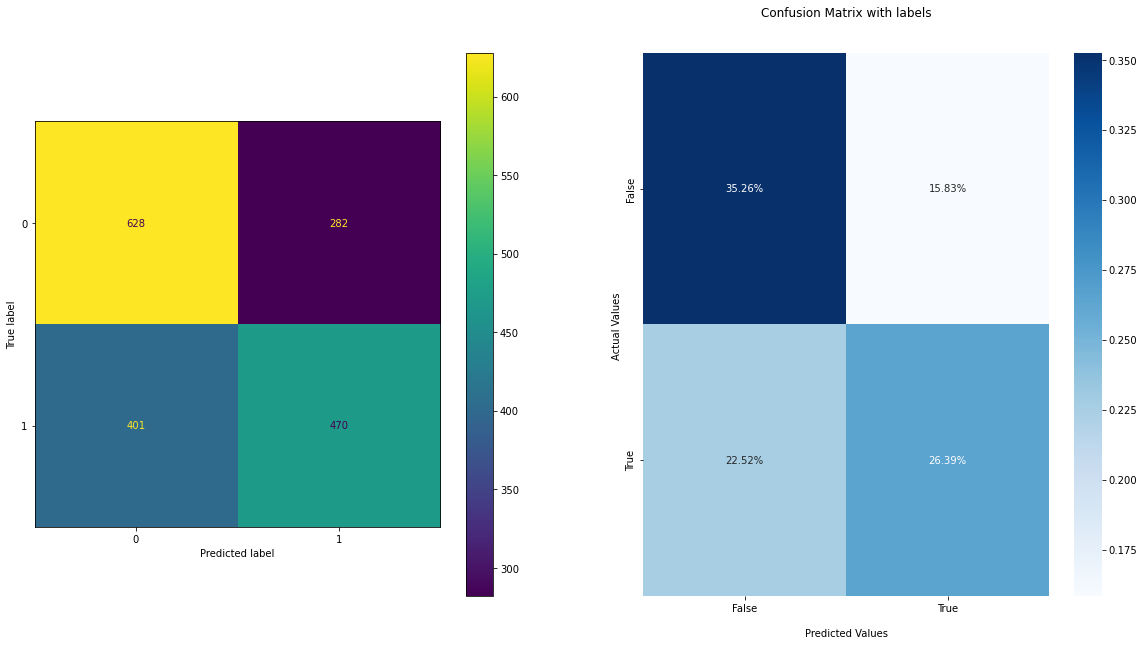

In [319]:
# Confusion Matrix

fig,ax = plt.subplots(1,2,figsize=(20,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(ax=ax[0]);


# Used this as template: 
# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#:~:text=To%20plot%20the%20confusion%20matrix%20with%20percentages%2C%20first%2C%20you%20need,the%20sum%20of%20all%20values.
a = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues', ax = ax[1])

a.set_title('Confusion Matrix with labels\n\n');
a.set_xlabel('\nPredicted Values')
a.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
a.xaxis.set_ticklabels(['False','True'])
a.yaxis.set_ticklabels(['False','True']);


In [263]:
accuracy = (tp+tn)/ (tp+fn+tn+fp)
accuracy

0.6165075800112296

In [264]:
misclass = 1 - accuracy
misclass

0.38349241998877037

In [265]:
recall = tp / (tp+fn)
recall

0.539609644087256

In [266]:
specificity = tn/ (tn+fp)
specificity

0.6901098901098901

In [267]:
precision = tp/(tp+fp)
precision

0.625

In [268]:
f1 = 2*precision*recall / (precision+recall)
f1

0.5791743684534811

In [288]:
df.iloc[[120,42]]

,title,id,created_utc,year,month,full_link,body_len,word_count,char_count,has_media,num_comments,commments_greater
120,What card did you mis-evaluate the worst on first impression?,t4tcr,1336032756,2012,5,https://www.reddit.com/r/dominion/comments/t4tcr/what_card_did_you_misevaluate_the_worst_on_first/,446,10,61,0,49,1
42,"New Dominion expansions announced (1 big, 1 small, 1 digital &amp; a base treasure/victory set)",oo3sc,1327019579,2012,1,https://www.reddit.com/r/dominion/comments/oo3sc/new_dominion_expansions_announced_1_big_1_small_1/,0,15,95,0,9,0


In [290]:
probability_df = pd.DataFrame({'title' : X_test['title'], 'true' : y_test, 
                               'predicted' : predictions,
    'probability_viral' : [x[1] for x in probabilities],
    'probability_low_interaction' : [x[0] for x in probabilities],
    'link': [df.iloc[x]['full_link'] for x in X_test.index]})

In [324]:
# top 10 believed to have low comments
probability_df.sort_values(by='probability_viral').head(20)

,title,true,predicted,probability_viral,probability_low_interaction,link
167,Dominion Storage solution: 5 boxes compacted to 2.,1,0,0.201075,0.798925,https://www.reddit.com/r/dominion/comments/uwjmw/dominion_storage_solution_5_boxes_compacted_to_2/
6192,Voyage bug?,1,0,0.219597,0.780403,https://www.reddit.com/r/dominion/comments/t8i46u/voyage_bug/
1269,Dominion League S13 Championship Match - Tomorrow at 18:00 UTC,0,0,0.225099,0.774901,https://www.reddit.com/r/dominion/comments/4d1qck/dominion_league_s13_championship_match_tomorrow/
3813,Dominion online down?,1,0,0.227320,0.772680,https://www.reddit.com/r/dominion/comments/fuye0a/dominion_online_down/
3928,Small Games Tournament 3,0,0,0.228046,0.771954,https://www.reddit.com/r/dominion/comments/g9fp17/small_games_tournament_3/
126,Dominion | Recommended Sets,0,0,0.231641,0.768359,https://www.reddit.com/r/dominion/comments/t95dt/dominion_recommended_sets/
3998,Small Games Tournament 4,0,0,0.232499,0.767501,https://www.reddit.com/r/dominion/comments/ghrbl6/small_games_tournament_4/
3744,Online rating,0,0,0.236490,0.763510,https://www.reddit.com/r/dominion/comments/fmsn26/online_rating/
5045,Way of the Frog Question,0,0,0.237767,0.762233,https://www.reddit.com/r/dominion/comments/m0udll/way_of_the_frog_question/
1461,Dominion League S15 Championship Match - Sunday at 18:00 UTC,0,0,0.242355,0.757645,https://www.reddit.com/r/dominion/comments/4qr9js/dominion_league_s15_championship_match_sunday_at/


In [295]:
# TOP 10 Mistakes- thought would NOT be viral
probability_df[probability_df['true'] != probability_df['predicted']].sort_values(by='probability_viral').head(10)

,title,true,predicted,probability_viral,probability_low_interaction,link
167,Dominion Storage solution: 5 boxes compacted to 2.,1,0,0.201075,0.798925,https://www.reddit.com/r/dominion/comments/uwjmw/dominion_storage_solution_5_boxes_compacted_to_2/
6192,Voyage bug?,1,0,0.219597,0.780403,https://www.reddit.com/r/dominion/comments/t8i46u/voyage_bug/
3813,Dominion online down?,1,0,0.227320,0.772680,https://www.reddit.com/r/dominion/comments/fuye0a/dominion_online_down/
80,lvl 45 on Isotropic with 3k games played AMA,1,0,0.243516,0.756484,https://www.reddit.com/r/dominion/comments/rl4ru/lvl_45_on_isotropic_with_3k_games_played_ama/
1819,Slowrolling in Dominion Online,1,0,0.244076,0.755924,https://www.reddit.com/r/dominion/comments/5mhbbp/slowrolling_in_dominion_online/
6745,Question about Bauble,1,0,0.258897,0.741103,https://www.reddit.com/r/dominion/comments/vaxrrc/question_about_bauble/
583,Deals on Dominion online,1,0,0.259069,0.740931,https://www.reddit.com/r/dominion/comments/2safjd/deals_on_dominion_online/
3054,Dominion online help,1,0,0.260382,0.739618,https://www.reddit.com/r/dominion/comments/aoap4z/dominion_online_help/
3876,Is there any way to report someone on dominion online?,1,0,0.262858,0.737142,https://www.reddit.com/r/dominion/comments/g3wl0j/is_there_any_way_to_report_someone_on_dominion/
349,"Resignation on 8th turn. Tournament, Tactician, Border Village, Baron, ... could this have been more efficient?",1,0,0.264847,0.735153,https://www.reddit.com/r/dominion/comments/12rmd0/resignation_on_8th_turn_tournament_tactician/


In [322]:
# Top ten believed to go viral
probability_df.sort_values(by='probability_viral').tail(10)

,title,true,predicted,probability_viral,probability_low_interaction,link
5425,Laminating cards,0,1,0.793602,0.206398,https://www.reddit.com/r/dominion/comments/ox70v2/laminating_cards/
3269,Expansion Recommendations based on liked Base Game Cards,0,1,0.794619,0.205381,https://www.reddit.com/r/dominion/comments/cd7sb2/expansion_recommendations_based_on_liked_base/
3587,Mini-expansion based on my alma mater (RPI),1,1,0.795888,0.204112,https://www.reddit.com/r/dominion/comments/er87he/miniexpansion_based_on_my_alma_mater_rpi/
2979,Discard clarification for Renaissance Cards,1,1,0.799648,0.200352,https://www.reddit.com/r/dominion/comments/aclo10/discard_clarification_for_renaissance_cards/
3115,Some less-than-half-baked fan card ideas,1,1,0.805280,0.194720,https://www.reddit.com/r/dominion/comments/b52k54/some_lessthanhalfbaked_fan_card_ideas/
5213,Which expansion to buy next for ESL family?,1,1,0.809034,0.190966,https://www.reddit.com/r/dominion/comments/nhsiby/which_expansion_to_buy_next_for_esl_family/
5342,Should I go simple or more complex with my fan card?,1,1,0.812931,0.187069,https://www.reddit.com/r/dominion/comments/oer156/should_i_go_simple_or_more_complex_with_my_fan/
3040,Opinions on the removed first edition Intrigue cards,1,1,0.813512,0.186488,https://www.reddit.com/r/dominion/comments/akwjbs/opinions_on_the_removed_first_edition_intrigue/
3671,Menagerie Previews 5: More Cards,1,1,0.815293,0.184707,https://www.reddit.com/r/dominion/comments/feac0w/menagerie_previews_5_more_cards/
4217,Do you take the placeholder cards?,1,1,0.830814,0.169186,https://www.reddit.com/r/dominion/comments/hpd2u7/do_you_take_the_placeholder_cards/


In [330]:
# TOP 10 mistakes- thought would be viral
probability_df[probability_df['true'] != probability_df['predicted']].sort_values(by='probability_viral').tail(10)

,title,true,predicted,probability_viral,probability_low_interaction,link
3965,Weekly Fan Card Concept May 3 - Quarantine,0,1,0.744016,0.255984,https://www.reddit.com/r/dominion/comments/gd1v4q/weekly_fan_card_concept_may_3_quarantine/
5817,"If a card states that each other player gains a copy if the card and there is not enough in the pile for all players, what should you do?",0,1,0.745995,0.254005,https://www.reddit.com/r/dominion/comments/rnrv37/if_a_card_states_that_each_other_player_gains_a/
6548,Cards: Apparition and Ward,0,1,0.752085,0.247915,https://www.reddit.com/r/dominion/comments/umydfd/cards_apparition_and_ward/
6643,I would buy a set with fan cards from CarlinePatricia,0,1,0.754026,0.245974,https://www.reddit.com/r/dominion/comments/uybjmd/i_would_buy_a_set_with_fan_cards_from/
6904,How often do you want to see Fan Cards?,0,1,0.755573,0.244427,https://www.reddit.com/r/dominion/comments/w37c9f/how_often_do_you_want_to_see_fan_cards/
3640,IRL Dominion Tracker - Getting Ready for Menagerie,0,1,0.759888,0.240112,https://www.reddit.com/r/dominion/comments/f5ce4q/irl_dominion_tracker_getting_ready_for_menagerie/
5358,Fan Card - Forced Migration,0,1,0.760547,0.239453,https://www.reddit.com/r/dominion/comments/ohluo2/fan_card_forced_migration/
6436,Fan Card: Prosperous Village 2.0,0,1,0.777012,0.222988,https://www.reddit.com/r/dominion/comments/u1glo4/fan_card_prosperous_village_20/
5425,Laminating cards,0,1,0.793602,0.206398,https://www.reddit.com/r/dominion/comments/ox70v2/laminating_cards/
3269,Expansion Recommendations based on liked Base Game Cards,0,1,0.794619,0.205381,https://www.reddit.com/r/dominion/comments/cd7sb2/expansion_recommendations_based_on_liked_base/


# Recommendations and Conclusions

This was a hard data problem and it is unsurprising that the model does not perform better. For a human, it is very difficult to read one of these titles and predict how popular the post will be compared to other posts and there are several reasons for this. A significant amount of information is hidden by just looking at words, in particular, the quality of any attached images is completely neglected. While the model did look at whether media was present, it is impossible to decipher whether the image is engaging or not without doing analysis on it. Further, many of the posts in this subreddit were questions about how the game is played and it is impossible for simple vectorizers to predict whether humans will have significant engagment with the post or just a few responses. Sometimes, a simple answer is all that is needed. Some of the posts did receive a bit of engagement, but were still shy of the median amount! I believe the model was able to pick up some of extreme cases, such as simple questions and spam content.

I do not believe more data or other models would significantly help the model, although performance may improve marginally. Modeling a much more measurable task that does not depend on human likes and engagement would be much more achievalbe. Or using a Subreddit with the posts more evenly split between garbage/spam posts and actual content would achieve much higher accuracy scores for this task. Since the Dominion subreddit contains an active and passionate userbase, it is very difficult to achieve a high accuracy on this task. Looking at which posts the model thought would go viral and not, the model increased odds for a post if it contained 'card' or 'expansion' while posts with 'question' in them and posts with unrelated text (spam generally) were often correctly identified. My hypotheses for why posts with 'question' in them received less comments is because once a user answers the questions, there is not much reason for others to post on it. 